In [1]:
# Import libraries to use 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings


In [2]:
# Definitions

# Function to generate netlist for ngspice
def generatenetlist(filename,Ic,N,Imax):
    with open(filename, 'w') as output:
        output.write(f'* Netlist for {N} stacked tapes\n') # Name of the circuit as a comment
        output.write('I1 0 1 100\n') # Current source

        Rt = np.zeros(N)+0.5E-6
        n = np.zeros(N)+30 # n for power law
        # Creating nodes for each resitor and inductor
        for i in range(N):
            j = i+1
            k = i+2
            output.write(f'R{j} 1 {k} {Rt[i]}\n')
            output.write(f'B{j} {k} 0 V=100E-6*pow((I(B{j})/{Ic[i]}),{n[i]})\n')
    
        output.write(f'.dc I1 0 {Imax} 5\n')
        output.write('.print dc  V(1) \n') # Since the voltage is clamped we only need the data of one tape
        output.write('.end\n')

In [3]:
# Function to run netlist in ngspice and get data
def gettingdata(filename):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    in_data = False
    in_data_after = False
    count_dash_line = 0
    count_space = 0
    data = []
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
            if in_data:
                if line.strip() == '':
                    in_data = False
                    count_dash_line = 0
                    count_space += 1
                    continue
                tmp = [float(x) for x in line.split()]
                data.append(tmp)

            if in_data_after:
                if line.strip() == '':
                    in_data_after = False
                    count_dash_line = 0
                    continue
                tmp = [float(x) for x in line.split()]
                data.append(tmp)

            if '----' in line:
                count_dash_line += 1
            if count_dash_line == 2 and not in_data:
                in_data = True

            if count_dash_line == 1 and count_space == 1 and not in_data_after:
                in_data_after = True

    data = np.asanyarray(data)
    Icable = data[:,1]
    Vt =  data[:,2] 
    return Icable,Vt 

In [4]:
# Fitting only exponential with 10 microV as voltage criteria

def model_func_exp10(I,Ic,n):
    V0 = 10E-6 # Considering the electric field criterion 10uV/m with length = 1 m
    return V0*(I/Ic)**n

def fit_exp10(I,V,Ic0,n0): #(Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func_exp10, I, V,(Ic0,n0))
    Ic,n = opt_parms
    return Ic,n

# First case: 10 tapes with n samples for each standard deviation

Assuptions:
- Voltage criterion for fitting model is 10 microV but in ngspice is 100 microV.
- The cutoff total voltage is 10 microV. 
- Ramping current up to 125% of the ideal critical current of the cable. 

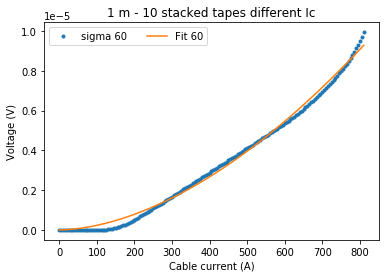

Fit 60: Ic = 845.0915719606118, n = 1.7655981530109062, Fit-error = 2.566866939980096e-06
Computing time:  327.95718968799997


<Figure size 432x288 with 0 Axes>

In [20]:
# Generating normal distributions with different standard deviations
#%matplotlib inline
warnings.filterwarnings("ignore") # Force shutting down of warnings

# Start timer 
start = timeit.default_timer()
 
N = 10 # Number of tapes
mu = 100 # mean value for Ic
sigma = np.array([1,3,5,10,15,20,25,30,40,50,60])
Nsample = 1000 # Number of samples per each standard deviation 
Imax = 1.25*N*mu # I added a some overcurrent of 25% for the cable current

Ic_array = [] # Array to save Ic from each sample
sd_Ic = []
n_array = [] # Array to save n from each sample
sd_n = []
Error_fit_array = [] # Array to save errors from fitting
sd_error = []

# random1 = int(random.random()*10)
random1 = 10
random2 = int(random.random()*10)

for i in range(len(sigma)):
    Ic_samples = []
    n_samples = []
    error_samples = []                      
    for j in range(Nsample):
        filename = f'{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'
        #filename = f'{N} tapes sd {sigma[i]} sample {j+1}.cir'
        Ic_dist = np.random.normal(mu, sigma[i], N)
        # Forcing data to be possitive in case Ic is negative
        for k in range(N):
            if Ic_dist[k] <= 0:
                Ic_dist[k] = 10. 
        
        # Generating netlist for specific sample
        generatenetlist(filename,Ic_dist,N,Imax) 
        
        # Running netlist in ngspice and getting data (cable current and total voltage)
        Icable,Vt = gettingdata(filename)
        
        # Second fitting removing resistive part
        Rt = 0.5E-6/N # Terminal resistance over number of tapes
        Vt_exp = Vt-Icable*Rt # Removing resistive part

        Vt_lim = []
        Icable_lim = []
        
        # Voltage limit
        for l in range(len(Vt_exp)):
            if Vt_exp[l] <= 10e-6: # Limit of the total voltage
                Vt_lim.append(Vt_exp[l])
                Icable_lim.append(Icable[l])

        Vt_lim = np.array(Vt_lim)
        Icable_lim = np.array(Icable_lim)

        # Exponential fitting
        Ic0,n0 = 100*N,30 # Initial values to fit exponential part
        Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
        #print(Ic_e,n_e)
        
        # Saving data from sample
        Ic_samples.append(Ic_e)
        n_samples.append(n_e)   
        
        # Getting curve from fitting 
        Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
        
        # Calculating fitting error
        Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
        error_samples.append(Error)
        #error_treshold = 
        
        # Plotting randomly one case
        if i == random1 and j == random2:
            plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
            plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit {sigma[i]}') #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
            plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
            plt.xlabel('Cable current (A)')
            plt.ylabel('Voltage (V)')
            plt.title(f'1 m - {N} stacked tapes different Ic')
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
            plt.show()
            plt.savefig('x.png')
            print(f'Fit {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
    
    # Arrays for Ic, n, and fit error for samples
    Ic_samples = np.array(Ic_samples)
    n_samples = np.array(n_samples) 
    error_samples = np.array(error_samples)
    
    # Calculating averages and standard deviation of samples
    Ic_array.append(np.average(Ic_samples))
    sd_Ic.append(np.std(Ic_samples))
    
    n_array.append(np.average(n_samples))
    sd_n.append(np.std(n_samples))
    
    Error_fit_array.append(np.average(error_samples))
    sd_error.append(np.std(error_samples))

# Converting averages and standard deviations into array type
Ic_array = np.array(Ic_array)
sd_Ic = np.array(sd_Ic)

n_array = np.array(n_array)
sd_n = np.array(sd_n)

Error_fit_array = np.array(Error_fit_array)
sd_error = np.array(sd_error)

# Saving data from average and sd arrays
fileaveragename = f'{N} tapes - {Nsample} samples'
with open(fileaveragename, 'w') as output:
    output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\n')
    for i in range(len(sigma)):
        output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\n')

# Stop timer
stop = timeit.default_timer()

print('Computing time: ', stop - start)

## Plotting absolute values of Ic, n, and fitting error

- We calculated the average and standard deviation for Ic distribution of the samples corresponding to each standard deviation.
- The standard deviation of the average is reported as error bars in the plots.

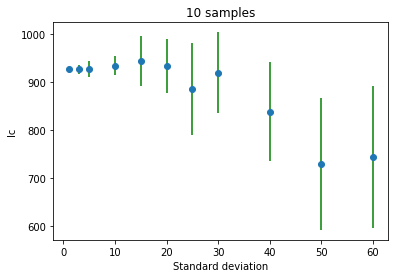

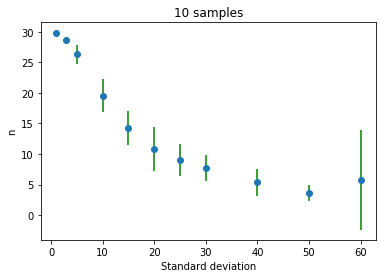

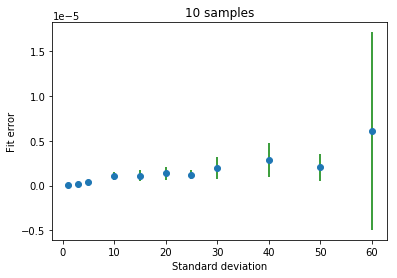

In [68]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()

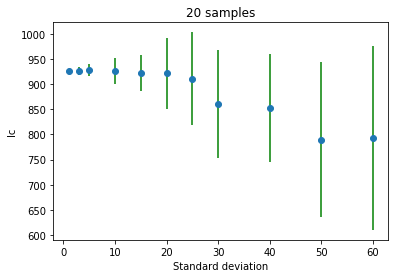

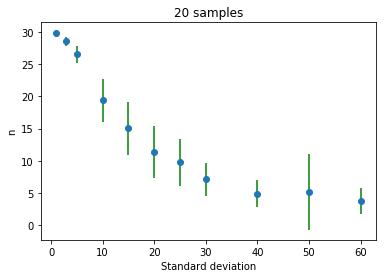

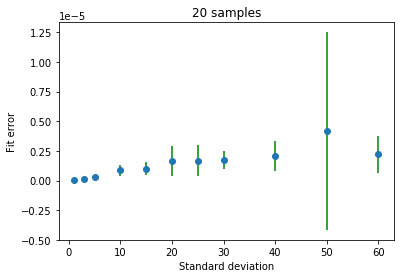

In [7]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()


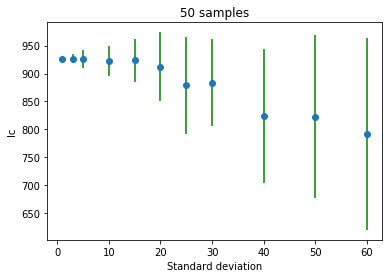

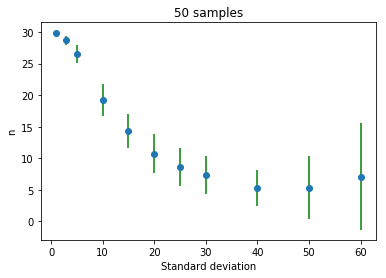

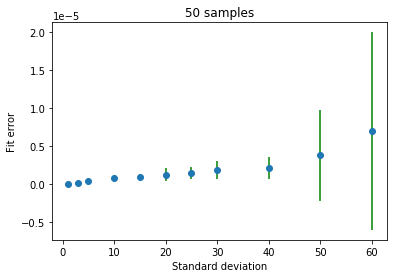

In [13]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()



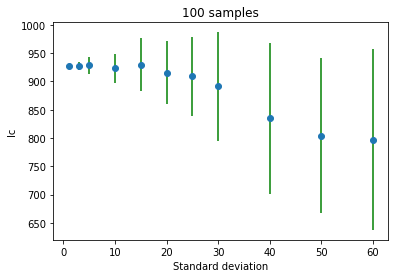

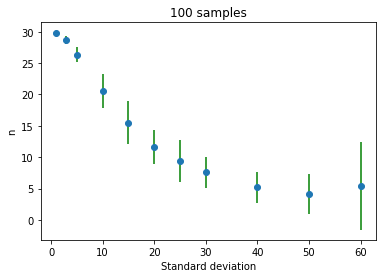

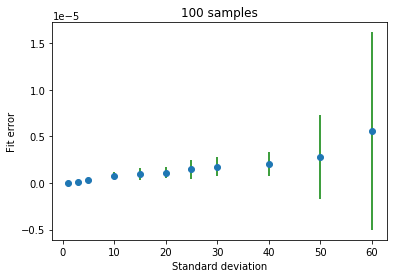

In [15]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()



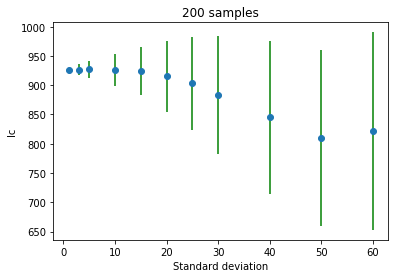

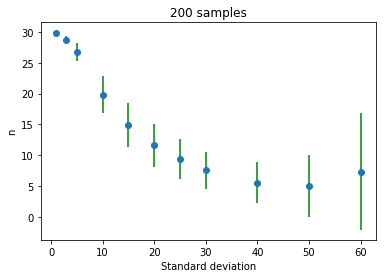

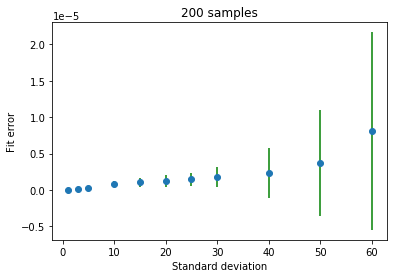

In [17]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()



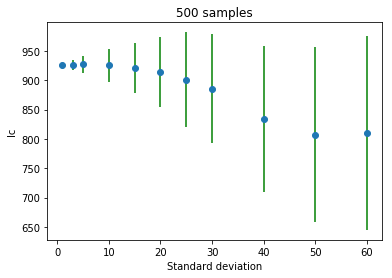

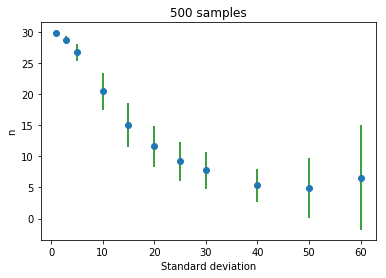

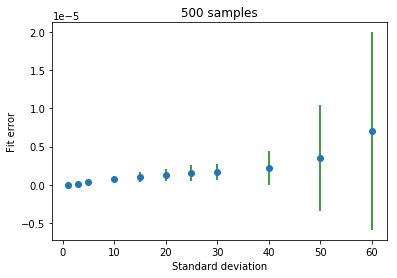

In [19]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()

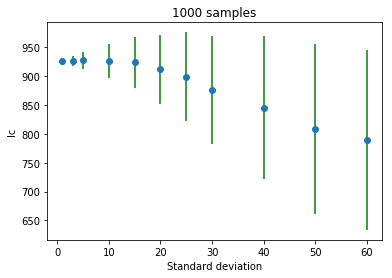

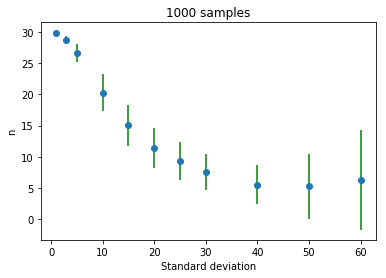

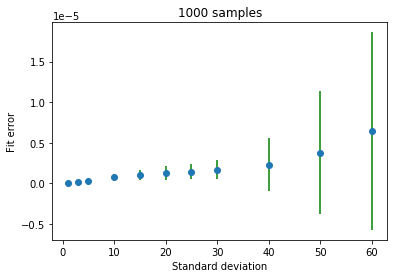

In [21]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()

### Cells after this point are irrelevant (they were used only for tests)

In [38]:
# Saving data from average and sd arrays
fileaveragename = f'{N} tapes - {Nsample} samples'
with open(fileaveragename, 'w') as output:
    output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\n')
    for i in range(len(sigma)):
        output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\n')


In [ ]:
out = subprocess.run(['ngspice', '-b', '10 tapes sd 5 sample 1.cir'], 
stdout=subprocess.PIPE,  stderr=subprocess.PIPE) # This line runs ngspice on shell 

with open('test.txt', 'w') as output:
    for line in out.stdout.decode('ascii').split('\n'):
        print(line)
        output.write(line)

In [ ]:
out = subprocess.run(['ngspice', '-b', '10 tapes sd 5 sample 1.cir'], stdout=subprocess.PIPE,  stderr=subprocess.PIPE)

in_data = False
in_data_after = False
count_dash_line = 0
count_space = 0
data = []
for line in out.stdout.decode('ascii').split('\n'):
    if in_data:
        if line.strip() == '':
            in_data = False
            count_dash_line = 0
            count_space += 1
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
    
    if in_data_after:
        if line.strip() == '':
            in_data_after = False
            count_dash_line = 0
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
        
    if '----' in line:
        count_dash_line += 1
    if count_dash_line == 2 and not in_data:
        in_data = True
    
    if count_dash_line == 1 and count_space == 1 and not in_data_after:
        in_data_after = True
        
data = np.asanyarray(data)
print(data)
Icable = data[:,1]
Vt =  data[:,2] + data[:,3]
V1 = data[:,4]
plt.plot(Icable,Vt)
plt.plot(Icable,V1,'rx')

In [ ]:
f = open("test.txt", "r")
contents =f.read()
#print(contents)

in_data = False
in_data_after = False
count_dash_line = 0
count_space = 0
data = []
for line in contents:
    if in_data:
        if line.strip() == '':
            in_data = False
            count_dash_line = 0
            count_space += 1
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
    
    if in_data_after:
        if line.strip() == '':
            in_data_after = False
            count_dash_line = 0
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
        
    if '----' in line:
        count_dash_line += 1
    if count_dash_line == 2 and not in_data:
        in_data = True
    
    if count_dash_line == 1 and count_space == 1 and not in_data_after:
        in_data_after = True
        
data = np.asanyarray(data)
print(data)
Icable = data[:,1]
Vt =  data[:,2] 
plt.plot(Icable,Vt)

Questions :

- Do we need to save the data from each distribution or is enough to generate them temporarly and create the .cir file 